## Static map creation notebook

#### Final output map represents number of buildings in Postal Code areas in Helsinki.

** **
  
Data is derived from City of Helsinki WFS-service.

Source and information about the data (in Finnish): https://www.hel.fi/helsinki/fi/kartat-ja-liikenne/kartat-ja-paikkatieto/Paikkatiedot+ja+-aineistot/avoimet+paikkatiedot/

Data (WFS layers) used to create the final map:
- Postal Code areas (Postinumeroalue)
- Buildings as points (Rakennukset_piste_rekisteritiedot)
- Main roads (Seutukartta_liikenne_paatiet)
- Sea area (Seutukartta_maankaytto_merialue)

In [1]:
# Import needed modules
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import CRS

In [2]:
"""
Read in data layers from WFS-service.
Keep only needed columns.
"""

# Postal Code areas
url = "https://kartta.hel.fi/ws/geoserver/avoindata/wfs?SERVICE=WFS&VERSION=1.1.0&REQUEST=GetFeature&TYPENAME=avoindata:Postinumeroalue&OUTPUTFORMAT=json"
areas = gpd.read_file(url)
areas = areas[['tunnus', 'geometry']]

# Buildings as points
url = "https://kartta.hel.fi/ws/geoserver/avoindata/wfs?SERVICE=WFS&VERSION=1.1.0&REQUEST=GetFeature&TYPENAME=avoindata:Rakennukset_piste_rekisteritiedot&OUTPUTFORMAT=json"
buildings = gpd.read_file(url)
buildings = buildings[['id', 'geometry']]

# Main roads
url = "https://kartta.hel.fi/ws/geoserver/avoindata/wfs?SERVICE=WFS&VERSION=1.1.0&REQUEST=GetFeature&TYPENAME=avoindata:Seutukartta_liikenne_paatiet&OUTPUTFORMAT=json"
roads = gpd.read_file(url)
roads = roads['geometry']

# Sea area
url = "https://kartta.hel.fi/ws/geoserver/avoindata/wfs?SERVICE=WFS&VERSION=1.1.0&REQUEST=GetFeature&TYPENAME=avoindata:Seutukartta_maankaytto_merialue&OUTPUTFORMAT=json"
sea = gpd.read_file(url)
sea = sea['geometry']

In [3]:
# Check that data´s CRS´s match
roads.crs == areas.crs == buildings.crs

True

In [4]:
# Join buildings to postal code areas using spatial join
joined = gpd.sjoin(areas, buildings, how="left")

# Check result
joined

,tunnus,geometry,index_right,id
0,00440,"POLYGON ((25492544.785 6680222.835, 25492467.3...",51072,51072
0,00440,"POLYGON ((25492544.785 6680222.835, 25492467.3...",27202,27196
0,00440,"POLYGON ((25492544.785 6680222.835, 25492467.3...",4922,4921
0,00440,"POLYGON ((25492544.785 6680222.835, 25492467.3...",35813,35812
0,00440,"POLYGON ((25492544.785 6680222.835, 25492467.3...",35819,35818
...,...,...,...,...
83,00550,"POLYGON ((25496941.575 6676429.337, 25496945.8...",36038,36037
83,00550,"POLYGON ((25496941.575 6676429.337, 25496945.8...",20835,20826
83,00550,"POLYGON ((25496941.575 6676429.337, 25496945.8...",18505,18488
83,00550,"POLYGON ((25496941.575 6676429.337, 25496945.8...",35743,35742


In [5]:
# Calculate the number of buildings in each postal code area
count = joined.groupby(['tunnus']).size().to_frame('size')

# New variable for postal code areas with calculated numbers of buildings
buildnum = areas.join(count, on=['tunnus'])

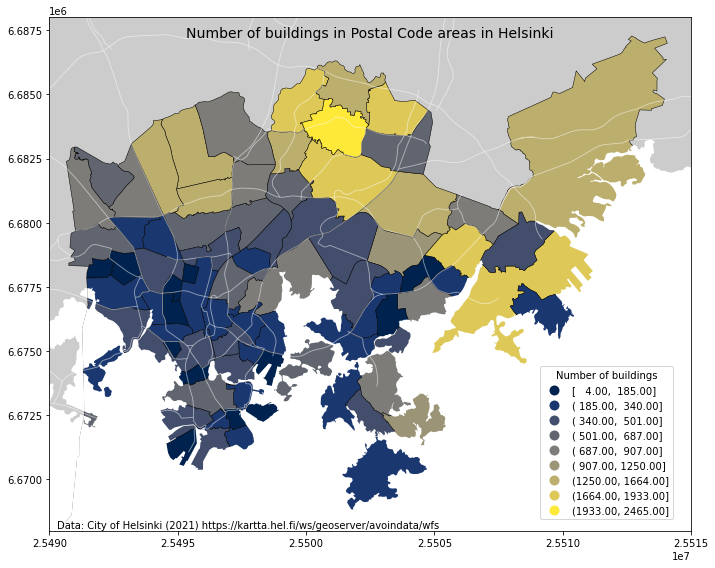

In [6]:
"""Plot the map"""

# Size and background color
fig, ax = plt.subplots(figsize=(12,8))
ax.set_facecolor((0.8, 0.8, 0.8))

# Visualize the number of buildings into 9 classes using "Natural Breaks" classification scheme
buildnum.plot(ax=ax, column="size", 
              cmap="cividis", 
              linewidth=0.5, 
              edgecolor="k", 
              scheme="NaturalBreaks", 
              k=9, 
              legend=True)


# Add sea and roads for visualization
sea.plot(ax=ax, color="w")
roads.plot(ax=ax, color="w", linewidth=0.9, alpha=0.5)

# Set map limits
ax.set_xlim(25490000, 25515000)
ax.set_ylim(6668000, 6688000)

# Set legend location, title and credits
ax.get_legend().set_bbox_to_anchor((0.98, 0.33))
ax.get_legend().set_title("Number of buildings")
ax.set_title("Number of buildings in Postal Code areas in Helsinki", fontsize=14, y=0.95)
ax.text(25490300, 6668100, "Data: City of Helsinki (2021) https://kartta.hel.fi/ws/geoserver/avoindata/wfs", fontsize=10)

# Remove the empty white-space around the axes
plt.tight_layout()

# Save the figure
outfp = "static_map.png"
plt.savefig(outfp, dpi=300)